# **Sentiment Classifier: Model Training**
In this notebook we will train the Sentiment Classification model on Google Play Reviews using BERT from HuggingFace library.

In [1]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
  print(f'Found GPU at: {device_name}')
else:
  raise SystemError('GPU not found!')

Found GPU at: /device:GPU:0


In [2]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print(f'There are {torch.cuda.device_count()} GPU(s) available!')
  print(f'Using GPU: {torch.cuda.get_device_name(0)}')
else:
  print(f'No GPUs available, using CPU instead!')
  device = torch.device("cpu")

There are 1 GPU(s) available!
Using GPU: Tesla P100-PCIE-16GB


# Installs


In [3]:
!pip install transformers

# https://github.com/JoMingyu/google-play-scraper
!pip install -qq google-play-scraper

# Scraping Reviews

User Reviews from 15 Productivity apps are scrapped from Google Play Store using google-play-scraper API. 

In [0]:
import json
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# pygments is a python syntax highlighter package. 
# A lexer splits the source into tokens, fragments of the source that have a token type that 
# determines what the text represents semantically (e.g., keyword, string, or comment). 
# JsonLexer is used for JSON data structures.
from pygments.lexers import JsonLexer  
# TerminalFormatter format tokens with ANSI color sequences, for output in a text console. 
# Color sequences are terminated at newlines, so that paging the output works correctly.
from pygments.formatters import TerminalFormatter
# Highlight is the most high-level highlighting function. It combines lex and format in one function.
from pygments import highlight  

from google_play_scraper import Sort, app, reviews

In [5]:
# Apps to extract reviews from
app_packages = [
    'com.anydo',
    'com.todoist',
    'com.ticktick.task',
    'com.habitrpg.android.habitica',
    'cc.forestapp',
    'com.oristats.habitbull',
    'com.levor.liferpgtasks',
    'com.habitnow',
    'com.microsoft.todos',
    'prox.lab.calclock',
    'com.gmail.jmartindev.timetune',
    'com.artfulagenda.app',
    'com.tasks.android',
    'com.appgenix.bizcal',
    'com.appxy.planner'
]

# Scrape full detail of the applications
app_infos = []
for application in tqdm(app_packages):
    info = app(application, lang='en', country='us')
    del info['comments']
    app_infos.append(info)


100%|██████████| 15/15 [00:02<00:00,  5.87it/s]


In [0]:
# Function to visualize json onjects with syntax highlighting
def print_json(json_object):
    """ This function takes as input Json Object and outputs a processed version containing syntax highlighting markup.""" 
    # json.dumps serializes 'obj' to JSON formatted 'str'.
    json_str = json.dumps(
        json_object,
        indent = 2,  # JSON array elements and object members will be pretty-printed with indent level 2  
        sort_keys=True,  # output of dictionaries will be sorted by key.
        default=str
    )
    print(highlight(json_str, JsonLexer(), TerminalFormatter()))  # combines lex and format in one function

In [7]:
print_json(app_infos[0])

{
  "adSupported": null,
  "androidVersion": "Varies",
  "androidVersionText": "Varies with device",
  "appId": "com.anydo",
  "containsAds": null,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "<b>\ud83c\udfc6 Editor's Choice by Google</b>\r\n\r\nAny.do is a To Do List, Calendar, Planner, Tasks & Reminders App That Helps Over 25M People Stay Organized and Get More Done.\r\n\r\n<b>\ud83e\udd47 \"It\u2019s A MUST HAVE PLANNER & TO DO LIST APP\" (NYTimes, USA TODAY, WSJ & Lifehacker).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists and more.\r\n\r\n\ud83d\udcc5 Organize Your Tasks & To-Do List in Seconds\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do list & planner support daily calendar view, 3-day C

In [8]:
# Create Dataframe of extracted app information
app_infos_df = pd.DataFrame(app_infos)
app_infos_df.head()

,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,saleTime,originalPrice,saleText,offersIAP,size,androidVersion,androidVersionText,developer,developerId,developerEmail,developerWebsite,developerAddress,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,appId,url
0,"Any.do: To do list, Calendar, Planner & Reminders",<b>🏆 Editor's Choice by Google</b>\r\n\r\nAny....,<b>🏆 Editor&#39;s Choice by Google</b><br><br>...,Task Manager ✅ Organizer 📅 Agenda 📝 Daily Remi...,Task Manager ✅ Organizer 📅 Agenda 📝 Daily Remi...,"10,000,000+",10000000,4.396980,347188,123486,"[29655, 9825, 14933, 31395, 261378]",0,True,USD,False,None,None,None,True,Varies with device,Varies,Varies with device,Any.do Calendar & To-Do List,5304780265295461149,feedback+androidtodo@any.do,https://www.any.do,"Any.do Inc.\n\n6 Agripas Street, Tel Aviv\n62...",https://www.any.do/privacy,5304780265295461149,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/zgOLUXCHkF91...,https://lh3.googleusercontent.com/umhDP6phYKbu...,[https://lh3.googleusercontent.com/DKoi-PetUjx...,https://www.youtube.com/embed/2nkllLD0x6o?ps=p...,https://i.ytimg.com/vi/2nkllLD0x6o/hqdefault.jpg,Everyone,None,None,None,"Nov 10, 2011",1591167996,Varies with device,→ Create tasks and reminders with natural lang...,→ Create tasks and reminders with natural lang...,com.anydo,https://play.google.com/store/apps/details?id=...
1,"Todoist: To-Do List, Tasks & Reminders","🏆 <b>2019 Editor's Choice</b> by Google\r\n🥇 ""...",🏆 <b>2019 Editor&#39;s Choice</b> by Google<br...,"""The best to-do list"" — The Verge. Tasks ✅ Rem...",&quot;The best to-do list&quot; — The Verge. T...,"10,000,000+",10000000,4.570280,200831,61406,"[6990, 3301, 7133, 34166, 149238]",0,True,USD,False,None,None,None,True,Varies with device,Varies,Varies with device,Doist,6748661820728732000,support@todoist.com,http://todoist.com,"Doist\n201 Mission Street, Suite 1200\nSan Fra...",https://todoist.com/Help/viewPrivacyPolicy,6748661820728732000,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/GK0SwEBVqlFB...,https://lh3.googleusercontent.com/sAjzU1fUnmqJ...,[https://lh3.googleusercontent.com/cealfl906mH...,None,None,Everyone,None,None,None,"Nov 18, 2012",1590154942,Varies with device,- ⚙️️ You can now use Sign in with Apple to qu...,- ⚙️️ You can now use Sign in with Apple to qu...,com.todoist,https://play.google.com/store/apps/details?id=...
2,"TickTick: ToDo List Planner, Reminder & Calendar",🏆Editor's Choice by Google\r\n🥇Great to-do lis...,🏆Editor&#39;s Choice by Google<br>🥇Great to-do...,Task & time manager by Editor’s Choice🏆. Get t...,Task &amp; time manager by Editor’s Choice🏆. G...,"1,000,000+",1000000,4.661570,60099,22460,"[1555, 818, 1676, 8311, 47737]",0,True,USD,False,None,None,None,True,Varies with device,Varies,Varies with device,Appest Inc.,7269704759597705101,ticktick.com@gmail.com,https://ticktick.com,FLAT/RM 1002C\nGINZA SQUARE\nNO.567 NATHAN ROA...,https://ticktick.com/about/privacy,7269704759597705101,Productivity,PRODUCTIVITY,https://lh3.googleusercontent.com/YSlqf3WBgIuN...,https://lh3.googleusercontent.com/m-kwaaJEP_P6...,[https://lh3.googleusercontent.com/6yyzsueMEND...,None,None,Everyone,None,None,None,"Jun 19, 2013",1589767029,Varies with device,"5700\r\n🌟 Enriched Habit choices, customizable...","5700<br>🌟 Enriched Habit choices, customizable...",com.ticktick.task,https://play.google.com/store/apps/details?id=...
3,Habitica: Gamify Your Tasks,Treat your life like a game to stay motivated ...,Treat your life like a game to stay motivated ...,Treat your life like a game to stay motivated ...,Treat your life like a game to stay motivated ...,"1,000,000+",1000000,4.256313,16006,6806,"[1162, 636, 1354, 2637, 10215]",0,True,USD,False,None,None,None,True,8.2M

The above dataframe contains complete information regarding each app used for this project. But we are interested in user reviews on each of these apps, which will scraped further on. But before, let's take a look at the icons of these apps. 

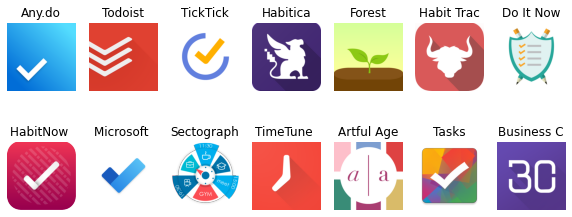

In [9]:
# Take a look at icons of apps
# Function to format Title of app 
def format_title(title):
    # Note: .find() returns -1 if value is not found. If value is found it returns index.
    # If ':' is not equal to -1 i.e. it finds ':' then return index of ':' else return index of '-'
    sep_index = title.find(':') if title.find(':') != -1 else title.find('-')
    return title[:sep_index][:10]

fig, axes = plt.subplots(nrows=2, ncols= len(app_packages) // 2  , figsize=(10,4))
for i, ax in enumerate(axes.flat):
    app_info = app_infos[i]
    img = plt.imread(app_info['icon'])  # Read an image from a file(a filename, a URL or a file-like object) into an array.
    ax.imshow(img)  # Display an image, i.e. data on a 2D regular raster.
    ax.set_title(format_title(app_info['title']))
    ax.axis('off')

Let's scrape the reviews!

In [10]:
# Scrape reviews for the application
app_reviews = []

# For each app in the list
for application in tqdm(app_packages):
    # For each score rating 
    for score in list(range(1,6)):
        # For most relevent and newest reviews 
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            # We will extract the reviews
            revs, _ = reviews(
                application,
                lang='en',
                country='us',
                sort=sort_order,
                count=200 if score == 3 else 100,  # Negative reviews(Score 1,2), Neutral (Score 3), Positive(4,5). Hence, Neutral required double.
                filter_score_with=score
            )
            for r in revs:
                r['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                r['appId'] = application
            app_reviews.extend(revs)

100%|██████████| 15/15 [00:50<00:00,  3.34s/it]


In [11]:
# Create Dataframe of scraped app reviews
app_reviews_df = pd.DataFrame(app_reviews)
#app_reviews_df.drop('reviewId', axis=1, inplace=True)
print(f'Total number of reviews: {app_reviews_df.shape[0]}')
app_reviews_df.head()

Total number of reviews: 15946


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOF_OBDJpMDUE3xGa8fbyCJDD3mM8z5AGNSIf4q...,Dominic Flanagan,https://lh3.googleusercontent.com/a-/AOh14Gjk1...,Pretty basic for the price. Lacks customisatio...,1,2,5.1.1.13,2020-05-28 16:23:37,Be advised that Any.do is a minimalistic task ...,2020-05-31 09:01:09,most_relevant,com.anydo
1,gp:AOqpTOHuZQkkDNAmNUpwfdnQSjZtvvwFoWVyPf5rWPk...,G Irish,https://lh3.googleusercontent.com/a-/AOh14Gjwg...,This last update has brought all kinds of bugs...,1,9,5.1.1.13,2020-05-23 01:40:48,Sorry about that! We are unaware of any issues...,2020-05-24 08:04:09,most_relevant,com.anydo
2,gp:AOqpTOENSETZVCAj3t-TMO9ZBmlqOLB9ujgQYdHbnj9...,Mohit Singla,https://lh3.googleusercontent.com/a-/AOh14GiJ0...,I have set daily reminders. It doesn't show th...,1,2,5.1.1.13,2020-05-29 03:05:47,The way Recurring Reminders work is that you n...,2020-05-31 09:23:29,most_relevant,com.anydo
3,gp:AOqpTOFTFzuwGKy1iy9NWAB-V53ZJusqDp-PumOpJOX...,Jesse Osby,https://lh3.googleusercontent.com/a-/AOh14Gh5M...,App is getting worse instead of better. Latest...,1,0,4.19.0.6,2020-06-01 15:58:18,There are several Any.do widget options to cho...,2020-06-02 07:05:14,most_relevant,com.anydo
4,gp:AOqpTOF3Kb-6IdEeeYLcuUncmzjQdtNguLU5GTshqNY...,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,17,5.0.0.11,2020-05-09 17:20:56,If you're having trouble figuring out how to t...,2020-05-12 08:22:05,most_relevant,com.anydo


Each row represents information regarding a single review. So, there are a total of somewhere around 16k scraped reviews. The nature/ sentiment of reviews contained in the column 'content' are derieved from the 'score' given by the reviewer. This score is basically called star rating which ranges from 1 to 5, where 1 being very bad and 5 being excellent. For the purpose of this project we will consider the rating of 1 & 2 as negative, 3 as neutral and 4 & 5 as positive. Below we will convert the score to negative (represented by 0), neutral (represented by 1), and positive (represented by 2).

In [0]:
# Convert ratings to sentiments
def rating_to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0  # negative
  elif rating == 3:
    return 1  # neutral
  else: 
    return 2  # positive


app_reviews_df['sentiment'] = app_reviews_df['score'].apply(rating_to_sentiment)

We will save the review dataframe to .csv file for further references. 

In [0]:
# Save reviews
app_reviews_df.to_csv('/content/reviews.csv', index=None, header=True)

In [14]:
app_reviews_df.shape

(15946, 13)

# Exploring Data
We will take a look at the reviews. For the purpose of exploring we will create a copy of our dataframe.

In [15]:
df = app_reviews_df.copy()
print(df.shape)
df.head()

(15946, 13)


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,sentiment
0,gp:AOqpTOF_OBDJpMDUE3xGa8fbyCJDD3mM8z5AGNSIf4q...,Dominic Flanagan,https://lh3.googleusercontent.com/a-/AOh14Gjk1...,Pretty basic for the price. Lacks customisatio...,1,2,5.1.1.13,2020-05-28 16:23:37,Be advised that Any.do is a minimalistic task ...,2020-05-31 09:01:09,most_relevant,com.anydo,0
1,gp:AOqpTOHuZQkkDNAmNUpwfdnQSjZtvvwFoWVyPf5rWPk...,G Irish,https://lh3.googleusercontent.com/a-/AOh14Gjwg...,This last update has brought all kinds of bugs...,1,9,5.1.1.13,2020-05-23 01:40:48,Sorry about that! We are unaware of any issues...,2020-05-24 08:04:09,most_relevant,com.anydo,0
2,gp:AOqpTOENSETZVCAj3t-TMO9ZBmlqOLB9ujgQYdHbnj9...,Mohit Singla,https://lh3.googleusercontent.com/a-/AOh14GiJ0...,I have set daily reminders. It doesn't show th...,1,2,5.1.1.13,2020-05-29 03:05:47,The way Recurring Reminders work is that you n...,2020-05-31 09:23:29,most_relevant,com.anydo,0
3,gp:AOqpTOFTFzuwGKy1iy9NWAB-V53ZJusqDp-PumOpJOX...,Jesse Osby,https://lh3.googleusercontent.com/a-/AOh14Gh5M...,App is getting worse instead of better. Latest...,1,0,4.19.0.6,2020-06-01 15:58:18,There are several Any.do widget options to cho...,2020-06-02 07:05:14,most_relevant,com.anydo,0
4,gp:AOqpTOF3Kb-6IdEeeYLcuUncmzjQdtNguLU5GTshqNY...,A Traveller,https://lh3.googleusercontent.com/-yutN8c-KH6U...,This app is a prime example of building a moun...,1,17,5.0.0.11,2020-05-09 17:20:56,If you're having trouble figuring out how to t...,2020-05-12 08:22:05,most_relevant,com.anydo,0


In [0]:
df.drop('reviewId', axis=1, inplace=True)

Visualizing review count for each Star Score (as originally scrapped).

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Reviews per Score(Star Rating)')

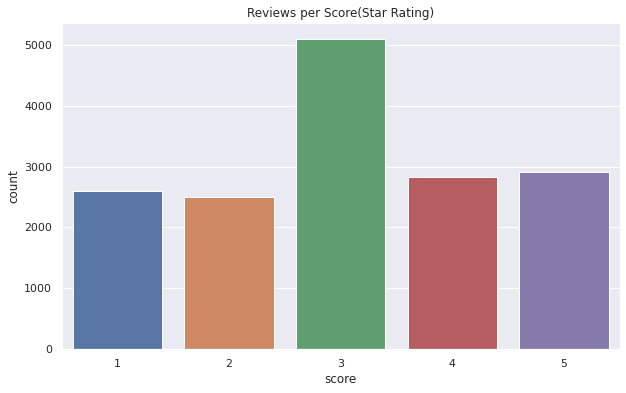

In [17]:
# Visualizing reviews count per star rating
import seaborn as sns; sns.set()
plt.rcParams['figure.figsize'] = 10,6
sns.countplot(df.score)
plt.title('Reviews per Score(Star Rating)')

Visualizing review count for each Sentiment (converted based on star scores). We had kept star score of 3 for neutral and combined the star scores of 1&2 for negative, and 4&5 for positive.

[Text(0, 0, 'negative'), Text(0, 0, 'neutral'), Text(0, 0, 'positive')]

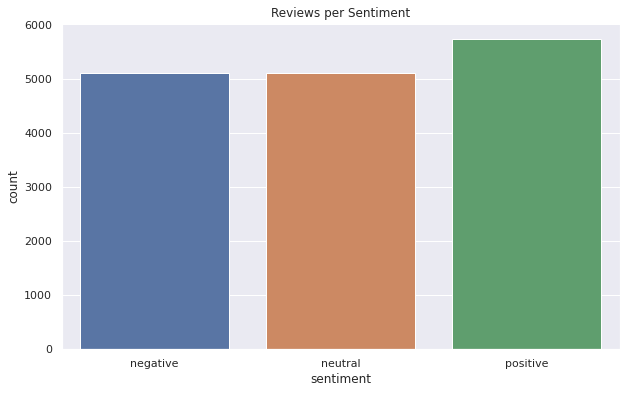

In [18]:
# Visualizing reviews count per sentiment
ax = sns.countplot(df.sentiment)
plt.title('Reviews per Sentiment')
ax.set_xticklabels(['negative', 'neutral', 'positive'])

Next, we will tokenize the reviews from the 'content' column and take a look at the length of the tokens. Base on this number we will choose our maximum length for the purpose of modeling BERT Sentiment Classifier.

We will use BertTokenizer derieved from pretrained BERT Base Cased model from the transformers library to create tokens. 

In [0]:
# Choosing Maximum Sequence Length
import transformers
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')

token_lens = []
for text in df.content:
    tokens = tokenizer.encode(text, max_length=512)
    token_lens.append(len(tokens))

(0.0, 200.0)

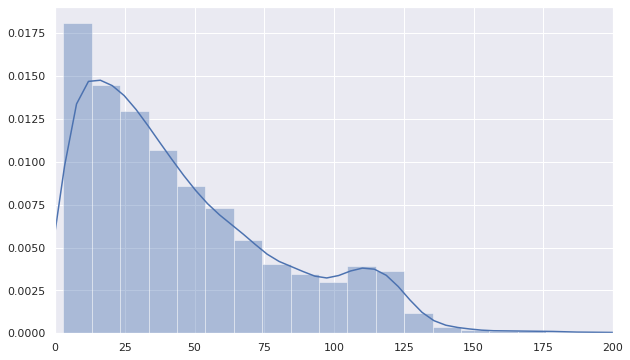

In [20]:
sns.distplot(token_lens)
plt.xlim(0, 200)

Basen on the above countplot, maximum length of reviews will be capped at 160 tokens each.

# Model Configuration

Set some paramaters for the project. Import the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI’s GPT and GPT-2.). Transformers provides a number of classes for applying BERT to different tasks. In this project, Pre-trained Bert Base Cased model is used.

In [0]:
import transformers

MAX_LEN = 150
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
EPOCHS = 10
RANDOM_SEED=42
CLASS_NAMES = ['negative', 'neutral', 'positive']


PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
#MODEL_PATH = 'model.bin'
TRAINING_FILE = '/content/reviews.csv'

TOKENIZER = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Dataset
Creating class for datasets.

In [0]:
import torch

class BERTDataset:
    """ Return input_ids, attention_masks, token_type_ids, targets """

    def __init__(self, review, target):
        self.review = review
        self.target = target
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN

    def __len__(self):
        """ This function returns the number of samples in text """
        return len(self.review)
 
    def __getitem__(self, item):
        """ This function returns the token_ids, attention_mask, and token_type_ids for each index in text """
        review = str(self.review[item])
        review = " ".join(review.split())
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'            
        )
        
        ids = inputs["input_ids"].flatten()
        mask = inputs["attention_mask"].flatten()

        return {
            "ids" : ids,
            "mask" : mask,
            "targets": torch.tensor(self.target[item], dtype=torch.long),           
        }

# Model
Setting up Model Architecture

In [0]:
import transformers
import torch.nn as nn

class BERTBaseCased(nn.Module):
    """ Returns model"""
    def __init__(self):
        """ Define Model Architecture """
        super(BERTBaseCased, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(0.3)
        self.linear = nn.Linear(768, 3)
        
    def forward(self, ids, mask):
        """ Implements the forward pass """
        last_hidden_state, pooler_output = self.bert(
            ids, 
            attention_mask=mask, 
        )
        output = self.drop(pooler_output)
        output = self.linear(output)
        return output

# Engine
Setting up model helper functions.

In [0]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm


def loss_fn(outputs, targets):
  return nn.CrossEntropyLoss()(outputs, targets).to(device)

def train_fn(data_loader, model, optimizer, device, scheduler, n_exp):
    model.train()

    correct_predictions = 0
    losses = []

    for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
        ids = d["ids"].to(device)
        mask = d["mask"].to(device)
        targets = d["targets"].to(device)

        #ids = ids.to(device, dtype=torch.long)
        #mask = mask.to(device, dtype=torch.long)
        #targets = targets.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask)
 
        _, indices = torch.max(outputs, dim=1)  

        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(indices == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #??????????
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / n_exp, np.mean(losses)

def eval_fn(data_loader, model, device, n_exp):
    model.eval()
    
    losses = []
    correct_predictions = 0
   
    with torch.no_grad():    
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"].to(device)
            mask = d["mask"].to(device)
            targets = d["targets"].to(device)

            #ids = ids.to(device, dtype=torch.long)
            #mask = mask.to(device, dtype=torch.long)
            #targets = targets.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask) 
            _, indices = torch.max(outputs, dim=1)  

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())
            
            correct_predictions += torch.sum(indices == targets)
            
    return correct_predictions.double() / n_exp, np.mean(losses)

# Train
Train the model

In [25]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import defaultdict 
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

# Read in CSV
df = pd.read_csv(TRAINING_FILE)

# Split into Validation
df_train, df_val = train_test_split(df, test_size=0.1, stratify=df.sentiment.values, random_state=RANDOM_SEED)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
print(df_train.shape, df_val.shape)

# Create Dataset required for BERT Model
train_dataset = BERTDataset(df_train.content.values, df_train.sentiment.values)
val_dataset = BERTDataset(df_val.content.values, df_val.sentiment.values)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, num_workers=1)

# Define Model and Hyperparameters
device = torch.device('cuda')
model = BERTBaseCased()
model.to(device)

num_training_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_training_steps=num_training_steps, num_warmup_steps=0)

# Train the Model, Print Aaccurcay, Save Model
n_train_exp = len(df_train)
n_val_exp = len(df_val)

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'\n{"#" * 10} Epoch: {epoch+1}/{EPOCHS} {"#" * 10}\n')
  train_acc, train_loss = train_fn(train_data_loader, model, optimizer, device, scheduler, n_train_exp)    
  val_acc, val_loss = eval_fn(val_data_loader, model, device, n_val_exp)

  print(f'\nTrain Loss: {train_loss:.4f}        Acc: {train_acc:.4f} \nVal   Loss: {val_loss:.4f}      Val Acc: {val_acc:.4f}')

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
      !rm -rf /content/model*
      torch.save(model.state_dict(), f'model_{val_acc:0.2f}.bin')
      best_accuracy = val_acc

(14351, 13) (1595, 13)

########## Epoch: 1/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.31it/s]



Train Loss: 0.7390        Acc: 0.6590 
Val   Loss: 0.6227      Val Acc: 0.7310

########## Epoch: 2/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.32it/s]



Train Loss: 0.4264        Acc: 0.8315 
Val   Loss: 0.5272      Val Acc: 0.8100

########## Epoch: 3/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.32it/s]



Train Loss: 0.2299        Acc: 0.9191 
Val   Loss: 0.5011      Val Acc: 0.8464

########## Epoch: 4/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.33it/s]



Train Loss: 0.1367        Acc: 0.9535 
Val   Loss: 0.5859      Val Acc: 0.8596

########## Epoch: 5/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.33it/s]



Train Loss: 0.1021        Acc: 0.9642 
Val   Loss: 0.6878      Val Acc: 0.8602

########## Epoch: 6/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.32it/s]



Train Loss: 0.0809        Acc: 0.9737 
Val   Loss: 0.7373      Val Acc: 0.8721

########## Epoch: 7/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.35it/s]


Train Loss: 0.0619        Acc: 0.9775 
Val   Loss: 0.7774      Val Acc: 0.8721

########## Epoch: 8/10 ##########




100%|██████████| 50/50 [00:07<00:00,  6.34it/s]



Train Loss: 0.0504        Acc: 0.9810 
Val   Loss: 0.7573      Val Acc: 0.8796

########## Epoch: 9/10 ##########



100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


Train Loss: 0.0398        Acc: 0.9840 
Val   Loss: 0.8297      Val Acc: 0.8721

########## Epoch: 10/10 ##########




100%|██████████| 50/50 [00:07<00:00,  6.33it/s]


Train Loss: 0.0358        Acc: 0.9848 
Val   Loss: 0.8420      Val Acc: 0.8727


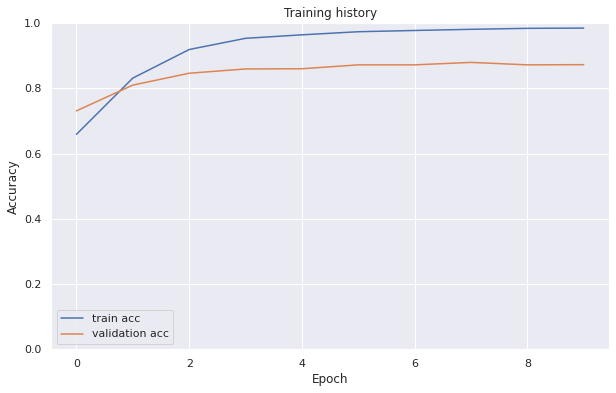

In [26]:
# Plot Accuracy
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,1]);

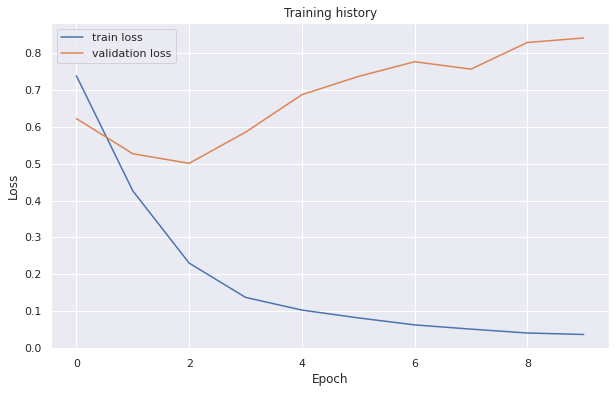

In [27]:
# Plot Loss
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([]);

In [28]:
pd.DataFrame(history)

,train_acc,train_loss,val_acc,val_loss
0,"tensor(0.6590, device='cuda:0', dtype=torch.fl...",0.738994,"tensor(0.7310, device='cuda:0', dtype=torch.fl...",0.622688
1,"tensor(0.8315, device='cuda:0', dtype=torch.fl...",0.426376,"tensor(0.8100, device='cuda:0', dtype=torch.fl...",0.527241
2,"tensor(0.9191, device='cuda:0', dtype=torch.fl...",0.229865,"tensor(0.8464, device='cuda:0', dtype=torch.fl...",0.501144
3,"tensor(0.9535, device='cuda:0', dtype=torch.fl...",0.136731,"tensor(0.8596, device='cuda:0', dtype=torch.fl...",0.585891
4,"tensor(0.9642, device='cuda:0', dtype=torch.fl...",0.102142,"tensor(0.8602, device='cuda:0', dtype=torch.fl...",0.687772
5,"tensor(0.9737, device='cuda:0', dtype=torch.fl...",0.080949,"tensor(0.8721, device='cuda:0', dtype=torch.fl...",0.737277
6,"tensor(0.9775, device='cuda:0', dtype=torch.fl...",0.061929,"tensor(0.8721, device='cuda:0', dtype=torch.fl...",0.777370
7,"tensor(0.9810, device='cuda:0', dtype=torch.fl...",0.050384,"tensor(0.8796, device='cuda:0', dtype=torch.fl...",0.757309
8,"tensor(0.9840, device='cuda:0', dtype=torch.fl...",0.039850,"tensor(0.8721, device='cuda:0', dtype=torch.fl...",0.829718
9,"tensor(0.9848, device='cuda:0', dtype=torch.fl...",0.035845,"tensor(0.8727, device='cuda:0', dtype=torch.fl...",0.841998


# Predicting on Raw Text

In [0]:
from torch.nn import functional as F

In [0]:
def get_prediction(sentence):
  tokenizer = TOKENIZER
  max_len = MAX_LEN
  sentence = str(sentence)
  sentence = " ".join(sentence.split())
  inputs = tokenizer.encode_plus(
      sentence,
      None,
      add_special_tokens=True,
      max_length=max_len,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_token_type_ids=False,
      return_tensors='pt'            
  )

  ids = inputs["input_ids"].to(device)
  mask = inputs["attention_mask"].to(device)
  
  model.eval
  outputs = model(ids=ids, mask=mask) #, token_type_ids=token_type_ids
  _, preds = torch.max(outputs, dim=1)  
  probs = F.softmax(outputs, dim=1)

  return sentence, CLASS_NAMES[preds], probs

In [0]:
sentence = "This has to be one of the best notepads in the store. It offers much more than basic/simple ones, yet it is not that complex when it becomes cumbersome. I like tabs, intuitive user interface, seamless switching from text to checklist (not many offer this), color coded folders, grid or list view, all together or folder view, check/lock/pin/stick, attachments. All good. Lack of sync with Google calendar does not bother me, it is clearly stated it won't be supported and it has its own basic calendar. Sketching tools could be improved (basic crop/resize, draw over imported image), but it's not a deal breaker for me.Why three stars then? Well, pricing is ridiculous. $5.5 for ONE WIDGET. And another $5.5 for a second widget (and third). And for colored status bar. And for search. And so on. Bundle is too expensive too, at $24. Before developer pastes a response App development is very expensive - I know that. You can ask whatever you think is a fair price. It's just when you look around the store, and see what others offer (both similar notepads, and other completely different apps), then this app seems way overpriced. If the price was $10, I believe much more people would buy it. Regards"

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
sentence, preds, probs = get_prediction(sentence)

print(f'Review text: {sentence}')
print(f'Sentiment  : {preds}')
print(f'Confidence : {probs}')

cuda:0
Review text: This has to be one of the best notepads in the store. It offers much more than basic/simple ones, yet it is not that complex when it becomes cumbersome. I like tabs, intuitive user interface, seamless switching from text to checklist (not many offer this), color coded folders, grid or list view, all together or folder view, check/lock/pin/stick, attachments. All good. Lack of sync with Google calendar does not bother me, it is clearly stated it won't be supported and it has its own basic calendar. Sketching tools could be improved (basic crop/resize, draw over imported image), but it's not a deal breaker for me.Why three stars then? Well, pricing is ridiculous. $5.5 for ONE WIDGET. And another $5.5 for a second widget (and third). And for colored status bar. And for search. And so on. Bundle is too expensive too, at $24. Before developer pastes a response App development is very expensive - I know that. You can ask whatever you think is a fair price. It's just when 